# DEG sorted by peak expression from BrainSpan

In [2]:
%cd work/notebooks

/home/jovyan/work/notebooks


In [3]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [8]:
import sys, os
sys.path.append('/home/jovyan/work/code')
from processing_helpers import *
from analysis_helpers import *
from gradientVersion import *
from mri_maps import *
from enrichments import *
from disorders import *
from brainspan import *
%R source("../code/enrichmentsPlots.R");
%R source("../code/plot_maps.R");

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down
Attaching package: ‘lemon’



    geom_pointpath, GeomPointPath



    %||%




In [5]:
dme_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')
version = dme_3d_ds5
scores = version.clean_scores()
weights = version.weights.iloc[:, :3].set_axis(['G1','G2','G3'], axis=1)

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


## Get BrainSpan curves

In [10]:
curves = get_brainspan_curves_by_gene(genes=weights.index)

In [15]:
q=10
quantiles = (weights
             .melt(ignore_index=False, var_name='G',value_name='G_score')
             .assign(G_quantile = lambda x: x.groupby('G')['G_score'].apply(lambda y: pd.qcut(y, q=q, labels=range(q))))
             .rename_axis('gene').reset_index()
)
quantiles

,gene,G,G_score,G_quantile
0,A1BG,G1,-0.015451,0
1,A1BG-AS1,G1,-0.011982,2
2,AAAS,G1,0.011610,8
3,AAED1,G1,-0.013839,1
4,AAGAB,G1,-0.005098,4
...,...,...,...,...
23914,ZSWIM9,G3,0.002506,5
23915,ZWINT,G3,0.000574,5
23916,ZYX,G3,-0.003733,3
23917,ZZEF1,G3,0.009702,8


In [16]:
quantile_curves = (quantiles
 .join(curves.set_index('gene'), on='gene').dropna()
 .groupby(['G','G_quantile','age_log10'])
 .agg({'pred':'mean'})
 .reset_index()
)
quantile_curves

,G,G_quantile,age_log10,pred
0,G1,0,1.748188,1.186535
1,G1,0,1.772677,1.193343
2,G1,0,1.797166,1.200146
3,G1,0,1.821655,1.206936
4,G1,0,1.846144,1.213701
...,...,...,...,...
2995,G3,9,4.074647,0.692634
2996,G3,9,4.099136,0.686422
2997,G3,9,4.123625,0.680166
2998,G3,9,4.148114,0.673888


/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "G_quantile". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


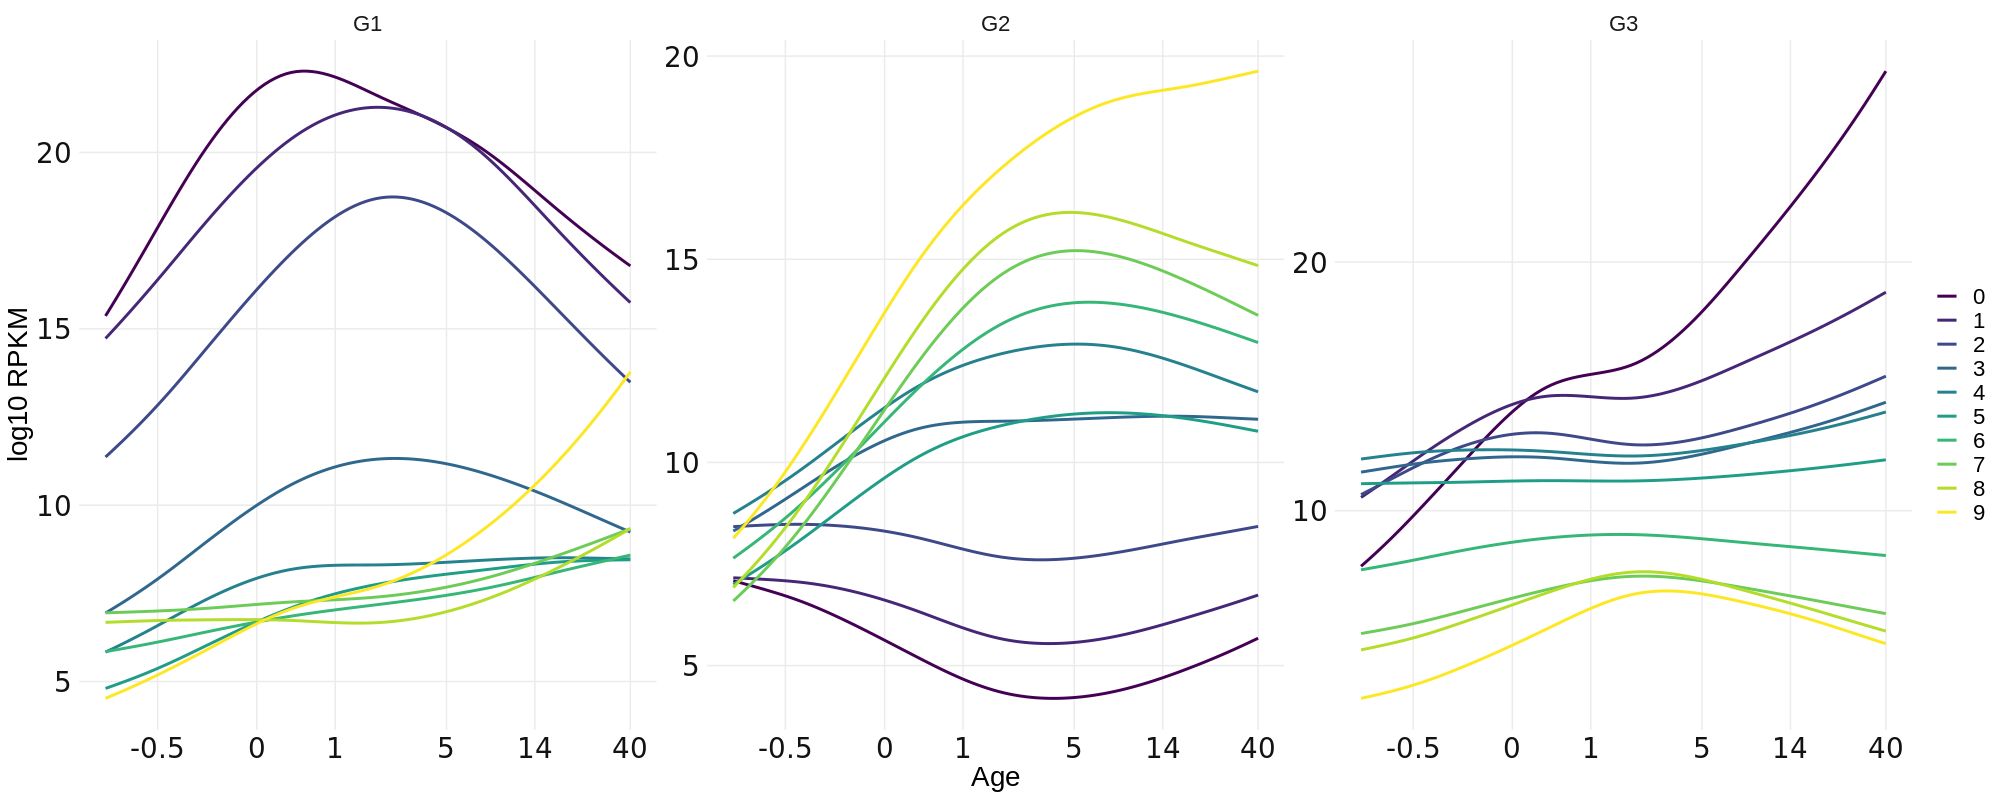

In [18]:
%%R -i quantile_curves -w 20 -h 8 -u in -r 100
source("../code/brainspanPlots.R")
quantile_curves %>% 
rename(label=G_quantile) %>% 
plot_quantile_curves(facet='~G')

## Get BrainSpan and find peak expression of every gene

In [9]:
bs_dir = "../data/brainspan-data/gene_matrix_rnaseq/"
bs_exp, bs_col, bs_row = get_brainspan(bs_dir)

In [365]:
hcp_bs_mapping = get_hcp_bs_mapping_v2()
bs_clean = clean_brainspan(bs_exp, bs_col, bs_row, hcp_bs_mapping)
bs_continuous = make_continuous(bs_clean, norm=True)

In [369]:
bs_continuous.set_index(['donor_id','gender','age','age_log10','region']).apply(lambda x: np.mean(x), axis=1).max()

1.0000000000000138

In [370]:
test_plot = (bs_continuous
             .set_index(['donor_id','gender','age','age_log10','region'])
             .loc[pd.IndexSlice[:,:,:,:,'DFC']]
            #  .apply(lambda x: x/np.quantile(x, .75), axis=1)
            #  .apply(lambda x: x/np.mean(x), axis=1)
             .sample(n=1000, axis=1).reset_index(2).melt(id_vars=['age'])
)
test_plot

,age,variable,value
0,56.0,KIAA1524,1.364457
1,63.0,KIAA1524,1.307596
2,84.0,KIAA1524,0.116308
3,84.0,KIAA1524,0.091092
4,84.0,KIAA1524,0.324215
...,...,...,...
34995,7945.0,PLAG1,-1.085242
34996,11230.0,PLAG1,-0.858449
34997,13420.0,PLAG1,-0.457210
34998,13785.0,PLAG1,-0.100196


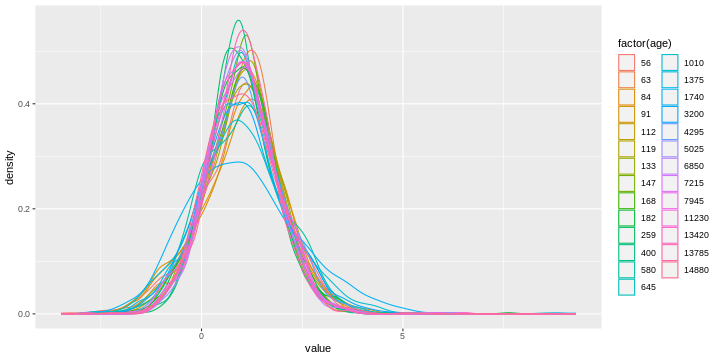

In [371]:
%%R -i test_plot -w 10 -h 5 -u in 
test_plot %>% 
ggplot(aes(x=value, color=factor(age), group=factor(age))) + 
geom_density() 

### Pick top and bottom genes from each axis

In [372]:
matched_genes = np.intersect1d(bs_clean.columns, weights.index)

n_rank = 4
posneg_genes = (pd.concat({
    'neg': weights.loc[matched_genes].rank(),
    'pos': weights.loc[matched_genes].rank(ascending=False)
    })
    .melt(ignore_index=False, var_name='G', value_name='rank')
    .query('rank<=@n_rank')
    .reset_index().rename({'level_0':'posneg', 'level_1':'gene'},axis=1)
    .assign(G = lambda x: x['G']+x['posneg'])
    # .sort_values(['G','rank'])
)

### Fit GAM to top n genes

In [373]:
# genes_to_fit = ['SST', 'MBP', 'GFAP', 'NEFL', 'LGALS1', 'SYT6']
genes_to_fit = posneg_genes['gene']
models = fit_gam_models(bs_continuous, genes_to_fit, alpha=.5)

### Predict smoothed curves

In [374]:
df_preds, df_data = predict_gam_curves(models, bs_continuous, genes_to_fit)
df_preds.head()

,age_log10,gender,region,gene,pred,pred_q75
0,1.748188,F,DFC,PEA15,3.024150,0.769142
1,1.748188,M,DFC,PEA15,2.968511,0.765828
2,1.772677,F,DFC,PEA15,3.037195,0.772460
3,1.772677,M,DFC,PEA15,2.981556,0.769194
4,1.797166,F,DFC,PEA15,3.050273,0.775786


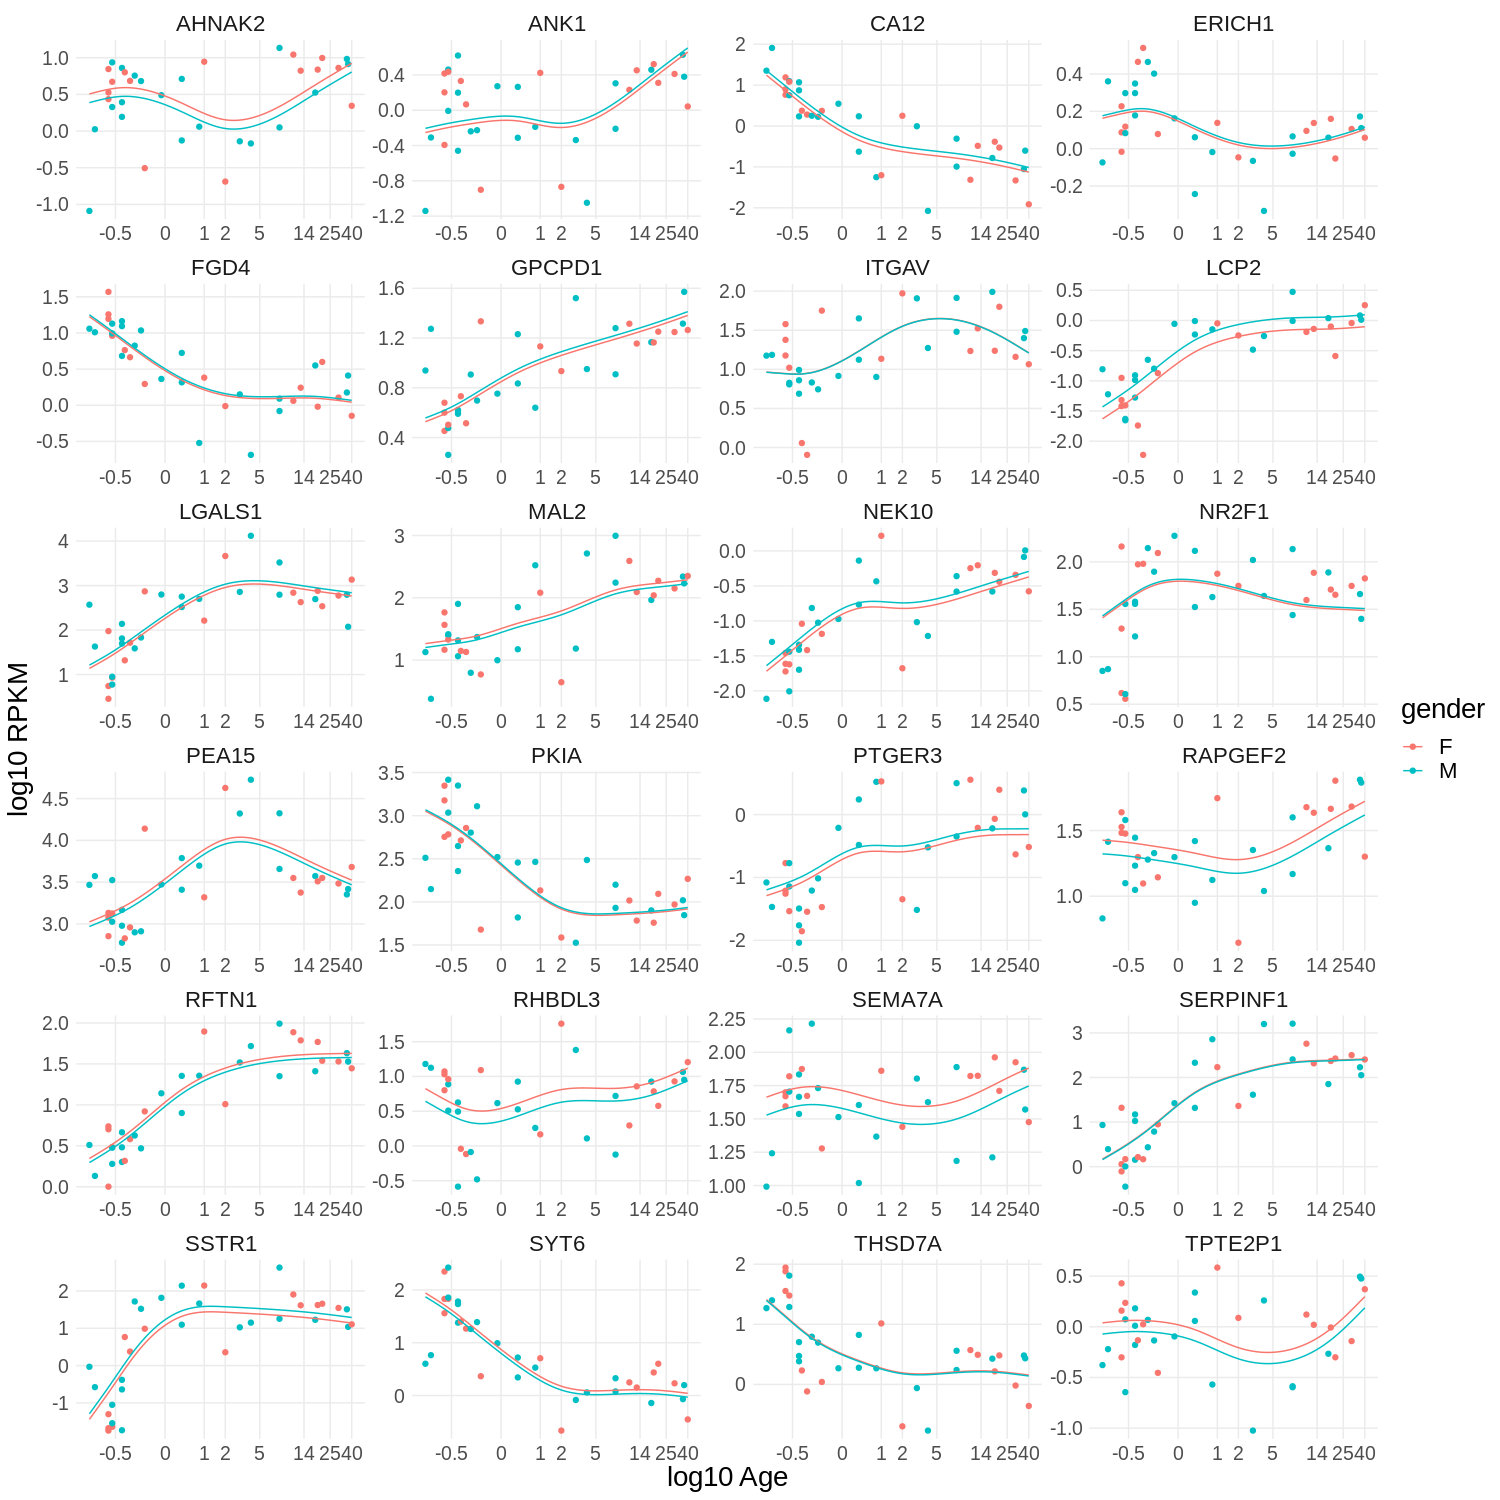

In [375]:
%%R -i df_data -i df_preds -w 15 -h 15 -u in -r 100
ggplot(mapping=aes(x=age_log10, color=gender)) + 
facet_wrap(~gene, scales='free', ncol=4) +
geom_point(aes(y=true), data=df_data) + 
geom_line(aes(y=pred), data=df_preds) +
scale_x_continuous(
    breaks=log10(c(-0.5,0,1,2,5,14,25,40)*365+40*7),
    labels=function(x) round((10**x - 40*7)/365,2)) +
ylab('log10 RPKM') +
xlab('log10 Age') +
theme_minimal() + 
theme(
    panel.grid.minor=element_blank(),
    text=element_text(size=20),
    axis.text=element_text(size=14)
)

## Fit models for all genes

In [376]:
matched_genes = np.intersect1d(bs_clean.columns, weights.index)
models_all = fit_gam_models(bs_continuous, matched_genes, alpha=.5)

In [377]:
curves_all, _ = predict_gam_curves(models_all, bs_continuous, matched_genes)

In [378]:
curves_all.groupby(['gene','gender','region']).apply(lambda x: np.quantile(x['pred_q75'],.75)).head()

gene   gender  region
A1BG   F       DFC       1.0
       M       DFC       1.0
AAAS   F       DFC       1.0
       M       DFC       1.0
AAGAB  F       DFC       1.0
dtype: float64

In [379]:
curves_100 = (curves_all
    .loc[lambda x: np.isin(x['gene'], np.random.choice(matched_genes, 100)), :]
    .groupby(['gene', 'age_log10']).mean()
    # .assign(z = lambda x: x.groupby('gene').apply(lambda y: (y-np.mean(y))/np.std(y)))
    # .assign(z = lambda x: x.groupby('gene').apply(lambda x: x/np.quantile(x, .75)))
    .reset_index()
)
curves_100

,gene,age_log10,pred,pred_q75
0,AAK1,1.748188,0.668277,0.607418
1,AAK1,1.772677,0.674436,0.613116
2,AAK1,1.797166,0.680551,0.618774
3,AAK1,1.821655,0.686574,0.624345
4,AAK1,1.846144,0.692453,0.629785
...,...,...,...,...
9995,ZNF880,4.074647,0.243689,0.462134
9996,ZNF880,4.099136,0.248133,0.470737
9997,ZNF880,4.123625,0.252728,0.479633
9998,ZNF880,4.148114,0.257418,0.488712


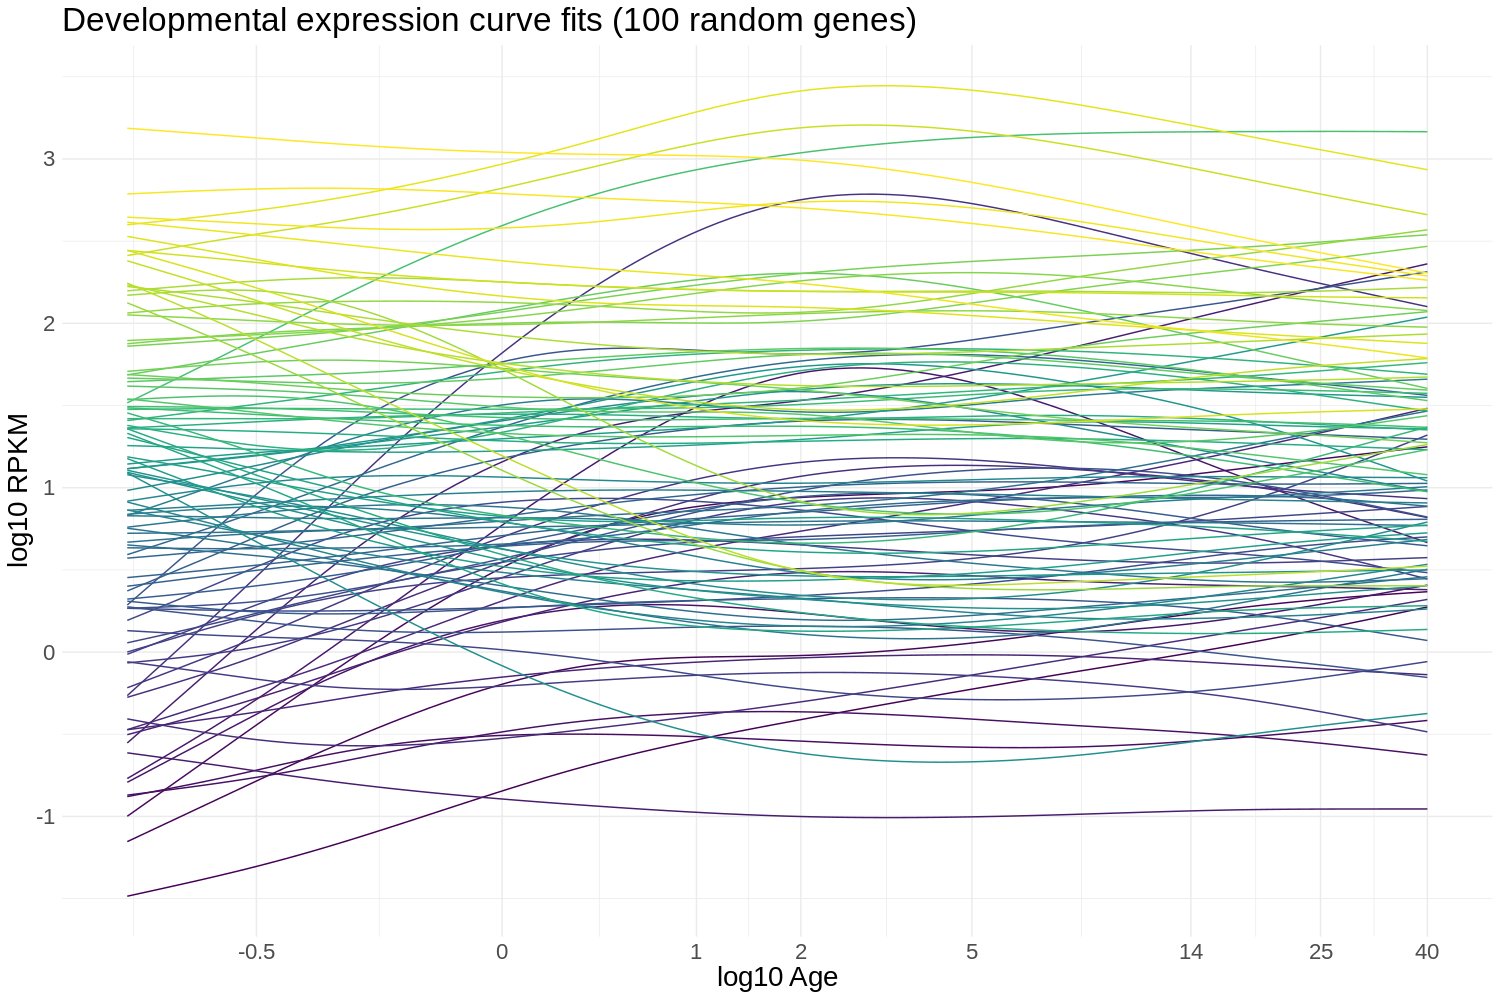

In [383]:
%%R -i curves_100 -w 15 -h 10 -u in -r 100
curves_100 %>% 
arrange(age_log10) %>% 
group_by(gene) %>% 
mutate(first = first(pred)) %>% 
ggplot(aes(x=age_log10, y=pred)) +
# mutate(first = first(pred_q75)) %>% 
# ggplot(aes(x=age_log10, y=pred_q75)) +
geom_line(aes(color=reorder(gene, first))) +
scale_color_viridis_d() +
scale_x_continuous(
    breaks=log10(c(-0.5,0,1,2,5,14,25,40)*365+40*7),
    labels=function(x) round((10**x - 40*7)/365,2)) +
ylab('log10 RPKM') +
xlab('log10 Age') +
theme_minimal() + 
theme(
    legend.position='none',
    text=element_text(size=20)
) + 
ggtitle('Developmental expression curve fits (100 random genes)')

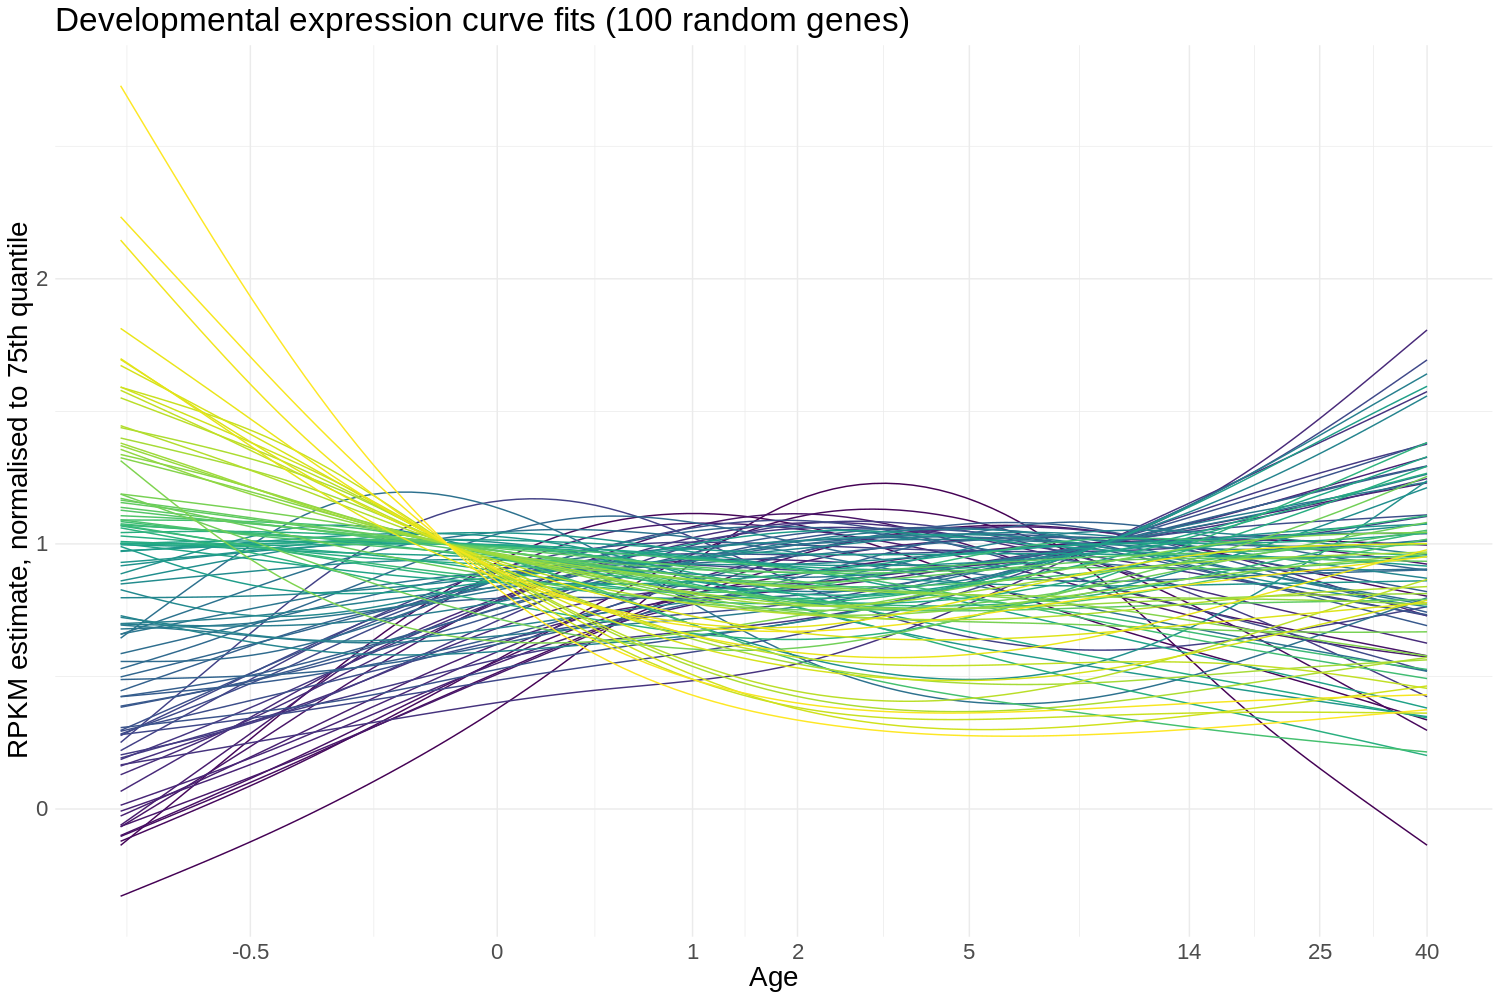

In [ ]:
%%R -i curves_z -w 15 -h 10 -u in -r 100
curves_z %>% 
arrange(age_log10) %>% 
group_by(gene) %>% 
mutate(first = first(z)) %>% 
ggplot(aes(x=age_log10, y=z)) +
geom_line(aes(color=reorder(gene, first))) +
scale_color_viridis_d() +
scale_x_continuous(
    breaks=log10(c(-0.5,0,1,2,5,14,25,40)*365+40*7),
    labels=function(x) round((10**x - 40*7)/365,2)) +
ylab('RPKM estimate, normalised to 75th quantile') +
xlab('Age') +
theme_minimal() + 
theme(
    legend.position='none',
    text=element_text(size=20)
) + 
ggtitle('Developmental expression curve fits (100 random genes)')

## Peak expression for all genes

In [395]:
peaks = (curves_all
        .groupby(['gene', 'age_log10']).mean()
        .loc[lambda x: x.groupby('gene')['pred'].rank(ascending=False)==1, :]
        .reset_index()
        .rename({'age_log10':'peak_age'}, axis=1)
        .join(weights, on='gene')
)
peaks

,gene,peak_age,pred,pred_q75,G1,G2,G3
0,A1BG,2.874684,0.743413,1.087695,-0.015451,-0.004937,0.000700
1,AAAS,1.748188,1.549599,1.394785,0.011610,0.004925,0.002747
2,AAGAB,4.172603,1.775881,1.090360,-0.005098,0.019884,-0.014749
3,AAK1,4.172603,1.466352,1.345737,0.013312,0.001277,-0.002644
4,AARS,4.172603,2.863820,1.056222,0.009904,0.014901,-0.011480
...,...,...,...,...,...,...,...
5991,ZSWIM7,3.266508,1.349958,1.028728,-0.008452,0.015128,0.001075
5992,ZWINT,1.748188,0.672171,5.764101,-0.012439,-0.008335,0.000575
5993,ZYX,2.188991,1.881332,1.018407,0.017013,0.005950,-0.003734
5994,ZZEF1,1.748188,1.020858,1.273564,0.013005,-0.012943,0.009699


In [396]:
peaks_plot = (peaks
    .melt(id_vars=['gene','peak_age','pred','pred_q75'], var_name='G', value_name='G_score')
    .assign(G_decile = lambda x: x.groupby('G').apply(lambda y: pd.qcut(y['G_score'], q=10, labels=range(10))).reset_index(0, drop=True))
    .sort_values('G_score', ascending=False)
    .assign(age_rank_in_decile = lambda x: x.groupby(['G','G_decile'])['peak_age'].rank(ascending=False, method='first'))
    .sort_values(['G_decile','age_rank_in_decile'])
)
peaks_plot

,gene,peak_age,pred,pred_q75,G,G_score,G_decile,age_rank_in_decile
8098,GSDMB,4.172603,0.057000,-0.288955,G2,-0.013782,0,1.0
3521,P2RX5,4.172603,0.925786,1.483801,G1,-0.014659,0,1.0
16102,RALBP1,4.172603,1.628501,1.078087,G3,-0.014749,0,1.0
11885,ZNF37BP,4.172603,0.426846,3.726835,G2,-0.013826,0,2.0
4088,RAB3GAP1,4.172603,1.771459,1.134659,G1,-0.014680,0,2.0
...,...,...,...,...,...,...,...,...
12362,ASPRV1,1.748188,0.276621,1.928584,G3,0.014720,9,599.0
1519,ELAVL4,1.748188,2.231300,1.325176,G1,0.013808,9,599.0
11484,TTLL12,1.748188,1.965486,1.239836,G2,0.015615,9,600.0
15428,NUDT1,1.748188,1.740715,1.533803,G3,0.014641,9,600.0


/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "G_decile". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


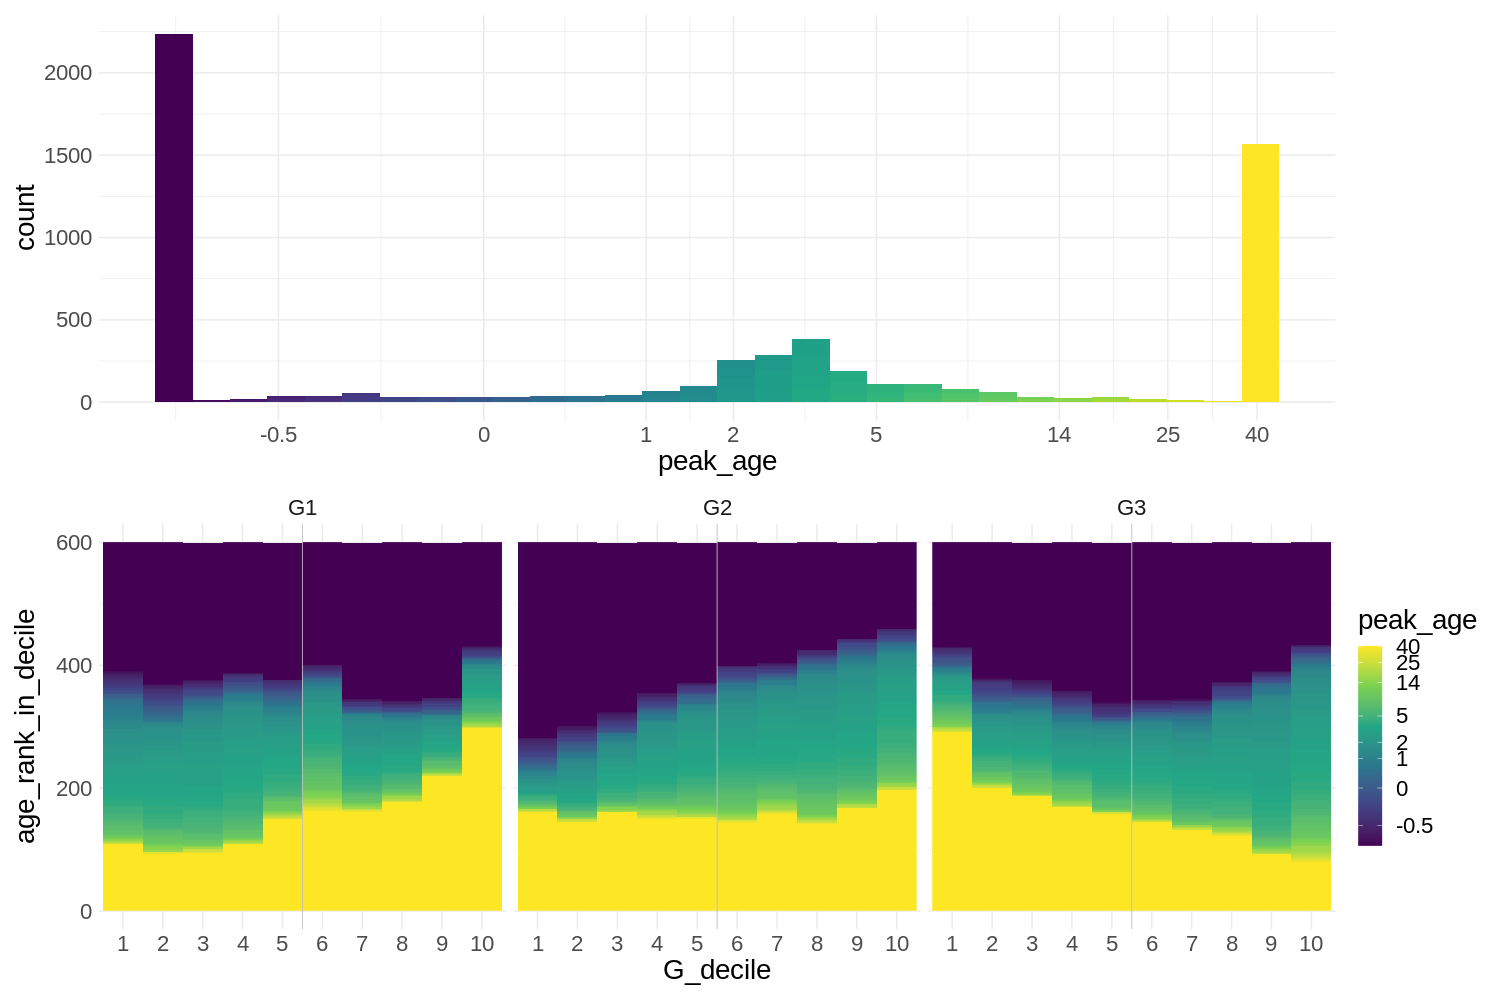

In [397]:
%%R -i peaks -i peaks_plot -w 15 -h 10 -u in -r 100
g1 <- peaks %>% 
    ggplot(aes(x=peak_age, fill=cut(peak_age,100))) + 
    geom_histogram() +
    scale_fill_viridis_d() +
    guides(fill='none') +
    scale_x_continuous(
        breaks=log10(c(-0.5,0,1,2,5,14,25,40)*365+40*7),
        labels=function(x) round((10**x - 40*7)/365,2))
g2 <- peaks_plot %>% 
    ggplot(aes(x=G_decile, y=age_rank_in_decile)) +
    facet_grid(.~G) + 
    geom_raster(aes(fill=peak_age)) + 
    geom_vline(xintercept=5.5, color='grey', size=.3) +
    scale_fill_viridis_c(
        breaks=log10(c(-0.5,0,1,2,5,14,25,40)*365+40*7),
        labels=function(x) round((10**x - 40*7)/365,2)) + 
    scale_x_discrete(
        labels=function(x) as.integer(x)+1
    ) +
    guides(fill=guide_colorbar(barheight=10))

(g1 / g2) & 
    theme_minimal() & theme(text=element_text(size=20))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "G_decile". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


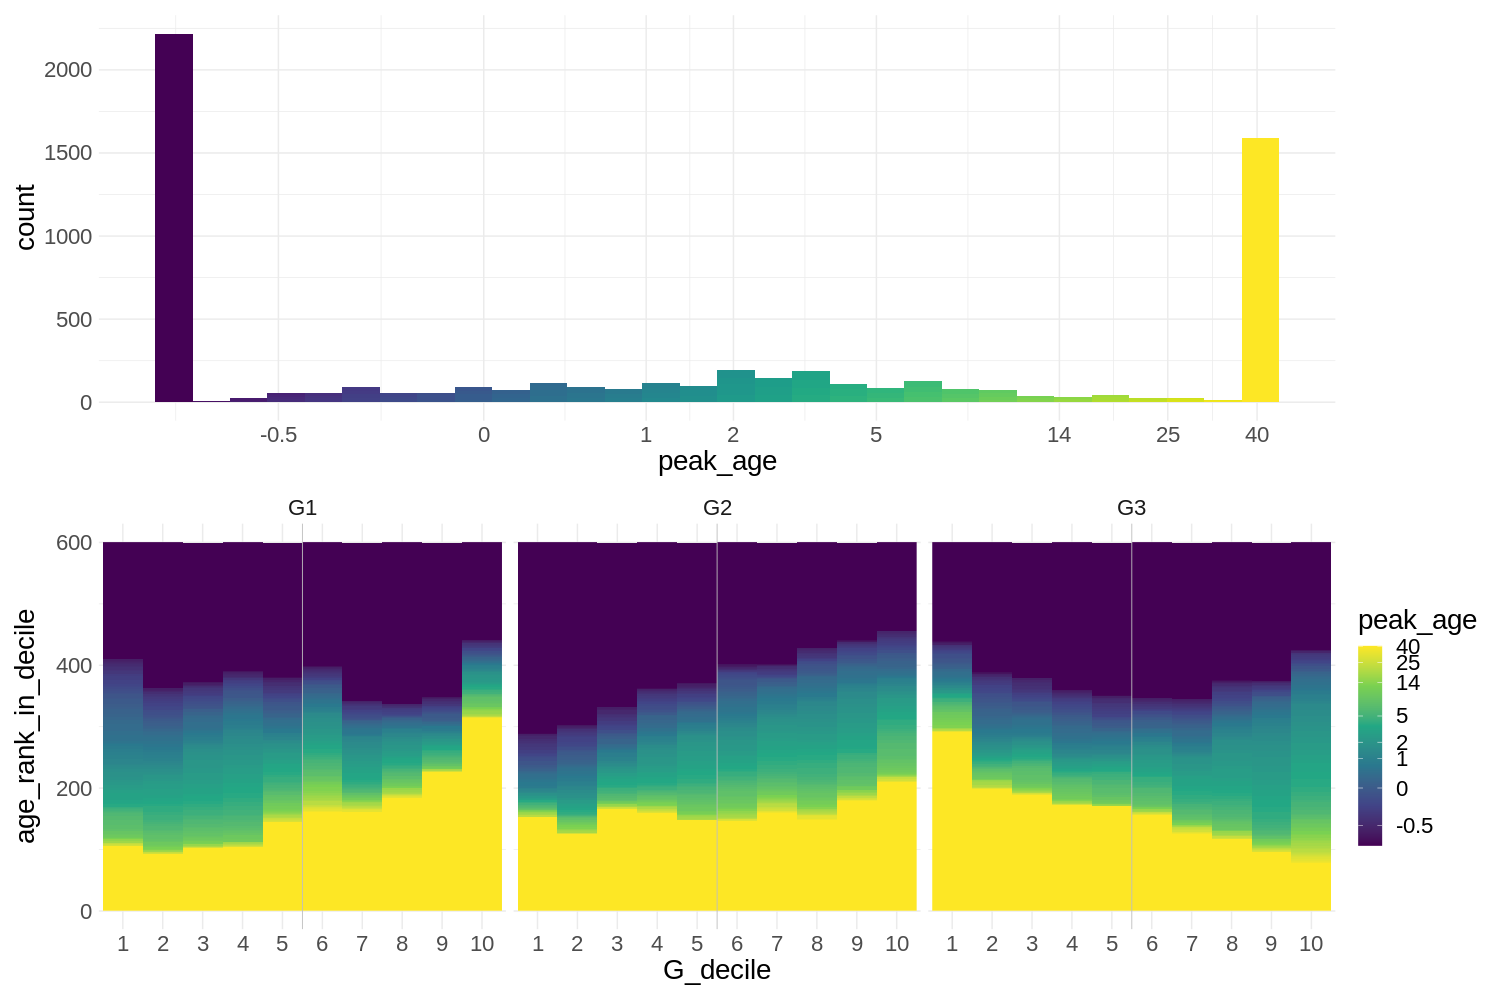

In [ ]:
%%R -i peaks -i peaks_plot -w 15 -h 10 -u in -r 100
g1 <- peaks %>% 
    ggplot(aes(x=peak_age, fill=cut(peak_age,100))) + 
    geom_histogram() +
    scale_fill_viridis_d() +
    guides(fill='none') +
    scale_x_continuous(
        breaks=log10(c(-0.5,0,1,2,5,14,25,40)*365+40*7),
        labels=function(x) round((10**x - 40*7)/365,2))
g2 <- peaks_plot %>% 
    ggplot(aes(x=G_decile, y=age_rank_in_decile)) +
    facet_grid(.~G) + 
    geom_raster(aes(fill=peak_age)) + 
    geom_vline(xintercept=5.5, color='grey', size=.3) +
    scale_fill_viridis_c(
        breaks=log10(c(-0.5,0,1,2,5,14,25,40)*365+40*7),
        labels=function(x) round((10**x - 40*7)/365,2)) + 
    scale_x_discrete(
        labels=function(x) as.integer(x)+1
    ) +
    guides(fill=guide_colorbar(barheight=10))

(g1 / g2) & 
    theme_minimal() & theme(text=element_text(size=20))

## DEGs

In [398]:
deg_dict = {
    # 'ASD Gandal 2022': pd.read_csv("../data/deg/gandal2022_tableS3.csv").loc[lambda x: x['WholeCortex_ASD_FDR']<=0.05, ['external_gene_name', 'WholeCortex_ASD_logFC']],
    # 'ASD Gandal 2018': pd.read_csv("../data/deg/gandal_genes_rnaseq.csv").loc[lambda x: x['ASD.fdr']<=0.05, ['gene_name', 'ASD.log2FC']],
    # 'ASD Parikshak 2016': pd.read_csv("../data/deg/parikshak2016_tableS2.csv", header=1, dtype={'Chr':'object', 'HGNC Symbol':'object'}).loc[lambda x: x['FDR-adjusted P value, ASD vs CTL']<=0.05, ['HGNC Symbol', 'log2(FC) ASD vs CTL']],
    # 'SCZ Collado-Torres 2019': pd.read_csv("../data/deg/colladotorres2019_tableS11.csv").query("region=='DLPFC'").loc[lambda x: x['adj.P.Val']<=0.05, ['Symbol', 'logFC']],
    'SCZ Collado-Torres 2019': pd.read_csv("../data/deg/colladotorres2019_tableS11.csv").loc[lambda x: x['adj.P.Val']<=0.05, ['Symbol', 'logFC']],
    'SCZ Gandal 2018': pd.read_csv("../data/deg/gandal_genes_rnaseq.csv").loc[lambda x: x['SCZ.fdr']<=0.05, ['gene_name', 'SCZ.log2FC']],
    'SCZ Jaffe 2018': pd.read_csv("../data/deg/jaffe2018_tableS9.csv", header=1).loc[lambda x: x['fdr_qsva']<=0.05, ['Symbol', 'log2FC_qsva']],
    'SCZ Fromer 2016': pd.read_csv("../data/deg/fromer2016_tableS3.csv", header=1).loc[lambda x: x['FDR estimate']<=0.05, ['Gene Symbol','logFC']],
}
deg_dict = {name:deg.set_axis(['gene', 'log2FC'], axis=1) for name, deg in deg_dict.items()}

deg_genes = pd.concat(deg_dict).reset_index(0).rename({'level_0':'label'}, axis=1)
deg_genes

,label,gene,log2FC
0,SCZ Collado-Torres 2019,NaN,0.183645
4,SCZ Collado-Torres 2019,EPHA8,0.212772
5,SCZ Collado-Torres 2019,ZNF436,0.071744
6,SCZ Collado-Torres 2019,ZNF436-AS1,0.090972
8,SCZ Collado-Torres 2019,RPS6KA1,-0.124236
...,...,...,...
688,SCZ Fromer 2016,LDB1,-0.097300
689,SCZ Fromer 2016,TXLNG,0.056600
690,SCZ Fromer 2016,DDX6,0.061700
691,SCZ Fromer 2016,DNAH11,0.171000


In [399]:
peaks_plot_with_degs = peaks_plot.copy()
for study in deg_genes['label'].unique():
    study_degs = deg_genes.loc[lambda x: x['label']==study, 'gene']
    peaks_plot_with_degs[study] = np.isin(peaks_plot_with_degs['gene'], study_degs)

peaks_plot_with_degs = (peaks_plot_with_degs
    .drop(['pred', 'pred_q75','G_score'], axis=1)
    .melt(id_vars=['gene','peak_age','G','G_decile','age_rank_in_decile'], var_name='study', value_name='in_study')
)
peaks_plot_with_degs

,gene,peak_age,G,G_decile,age_rank_in_decile,study,in_study
0,GSDMB,4.172603,G2,0,1.0,SCZ Collado-Torres 2019,False
1,P2RX5,4.172603,G1,0,1.0,SCZ Collado-Torres 2019,False
2,RALBP1,4.172603,G3,0,1.0,SCZ Collado-Torres 2019,False
3,ZNF37BP,4.172603,G2,0,2.0,SCZ Collado-Torres 2019,False
4,RAB3GAP1,4.172603,G1,0,2.0,SCZ Collado-Torres 2019,False
...,...,...,...,...,...,...,...
71947,ASPRV1,1.748188,G3,9,599.0,SCZ Fromer 2016,False
71948,ELAVL4,1.748188,G1,9,599.0,SCZ Fromer 2016,False
71949,TTLL12,1.748188,G2,9,600.0,SCZ Fromer 2016,False
71950,NUDT1,1.748188,G3,9,600.0,SCZ Fromer 2016,False


/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "G_decile". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


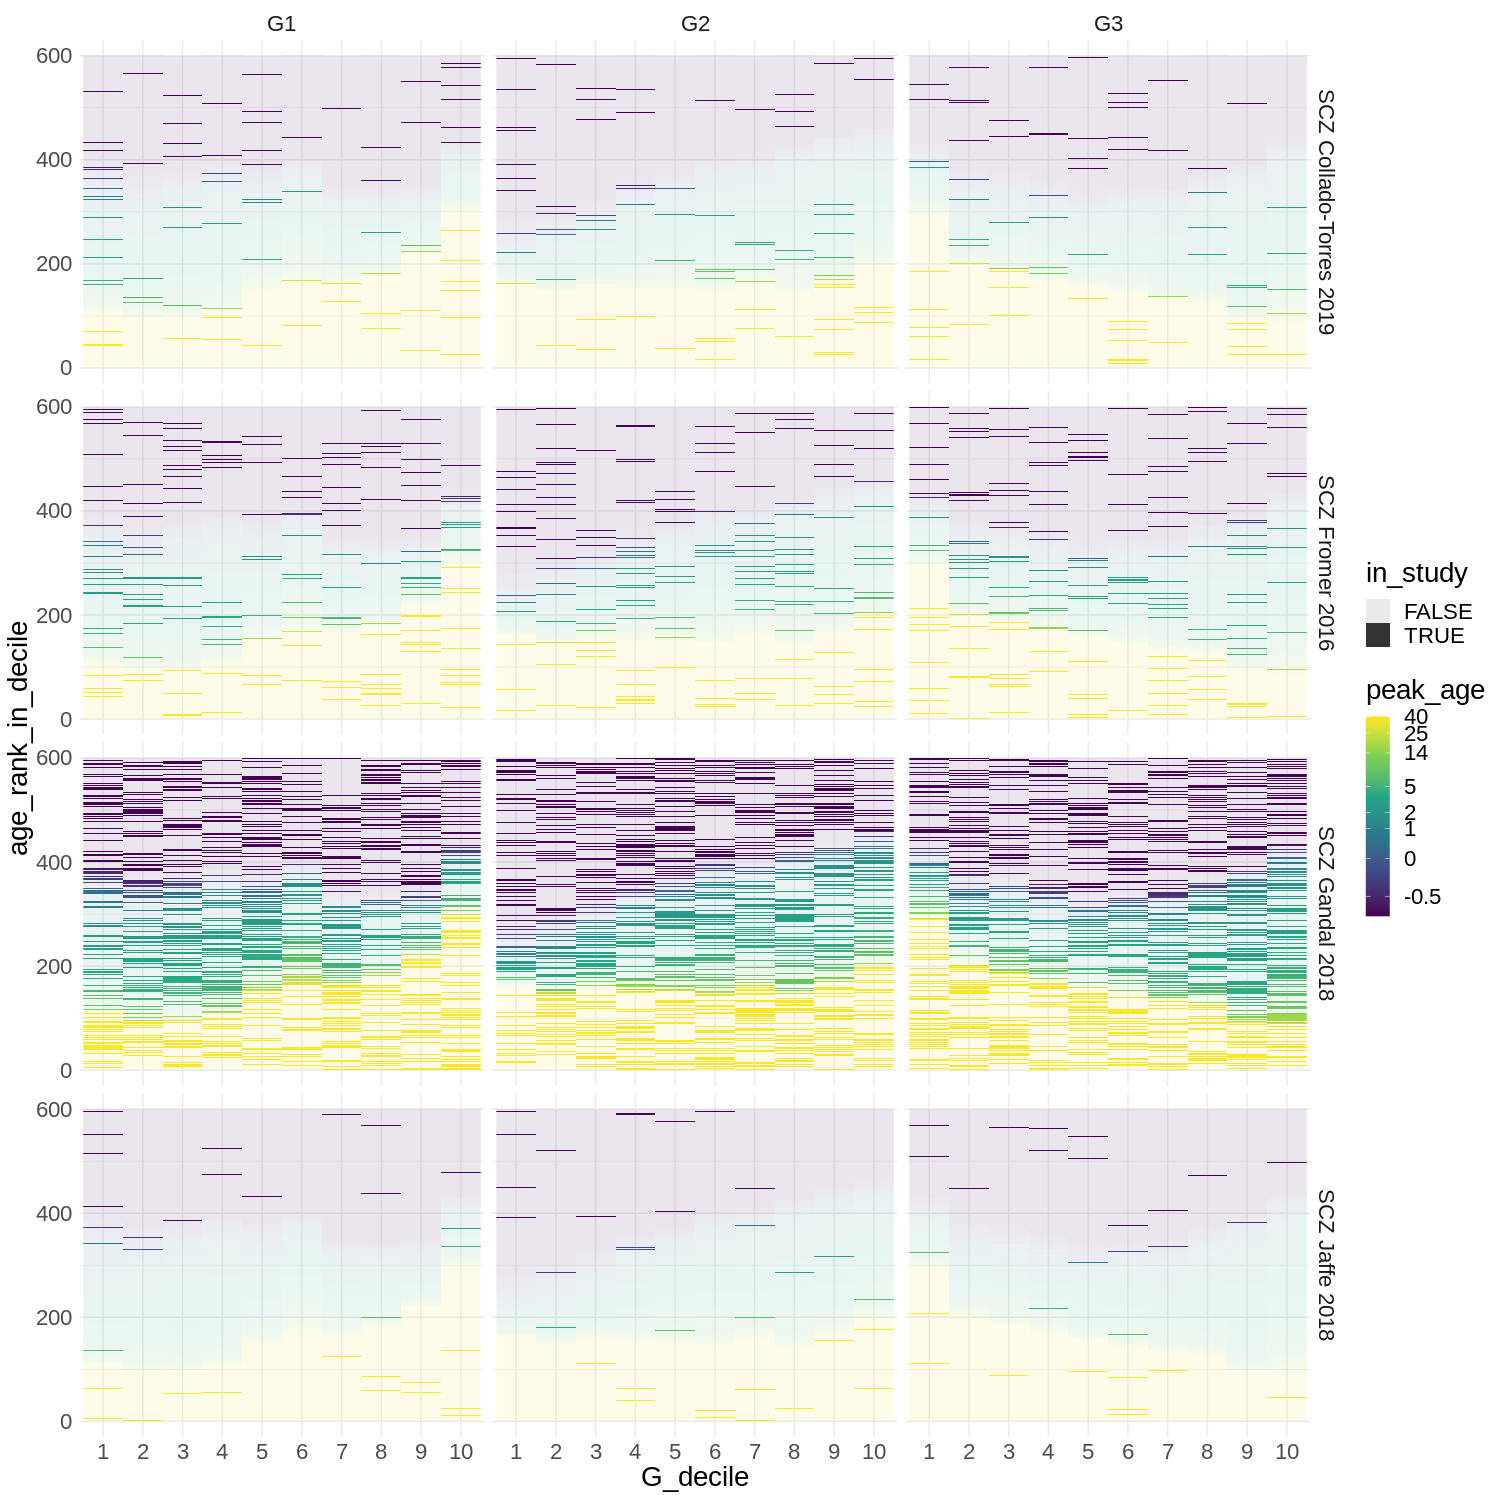

In [392]:
%%R -i peaks_plot_with_degs -w 15 -h 15 -u in -r 100
peaks_plot_with_degs %>% 
    ggplot(aes(x=G_decile, y=age_rank_in_decile)) +
    facet_grid(study~G) + 
    geom_raster(aes(fill=peak_age, alpha=in_study)) + 
    scale_alpha_manual(values=c(.1,1)) +
    scale_fill_viridis_c(
        breaks=log10(c(-0.5,0,1,2,5,14,25,40)*365+40*7),
        labels=function(x) round((10**x - 40*7)/365,2)) + 
    scale_x_discrete(
        labels=function(x) as.integer(x)+1
    ) +
    guides(fill=guide_colorbar(barheight=10)) +
    theme_minimal() + theme(text=element_text(size=20))

In [400]:
peaks_plot_with_degs_only = (peaks_plot_with_degs
    .loc[lambda x: x['in_study']]
    .assign(age_rank_in_decile = lambda x: x.groupby(['study','G','G_decile'])['peak_age'].rank(ascending=False, method='first'))
    .sort_values(['G_decile','age_rank_in_decile'])
)
peaks_plot_with_degs_only

,gene,peak_age,G,G_decile,age_rank_in_decile,study,in_study
47,ASPHD2,4.172603,G3,0,1.0,SCZ Collado-Torres 2019,True
126,PLXNC1,4.172603,G1,0,1.0,SCZ Collado-Torres 2019,True
173,GHR,4.172603,G2,0,1.0,SCZ Collado-Torres 2019,True
17996,CACNG2,4.172603,G3,0,1.0,SCZ Gandal 2018,True
17997,FBXO9,4.172603,G2,0,1.0,SCZ Gandal 2018,True
...,...,...,...,...,...,...,...
35953,FKBP5,1.748188,G3,9,228.0,SCZ Gandal 2018,True
35956,ZNF516,1.748188,G3,9,229.0,SCZ Gandal 2018,True
35962,B3GNT5,1.748188,G3,9,230.0,SCZ Gandal 2018,True
35965,TSPAN2,1.748188,G3,9,231.0,SCZ Gandal 2018,True


/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "G_decile". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '


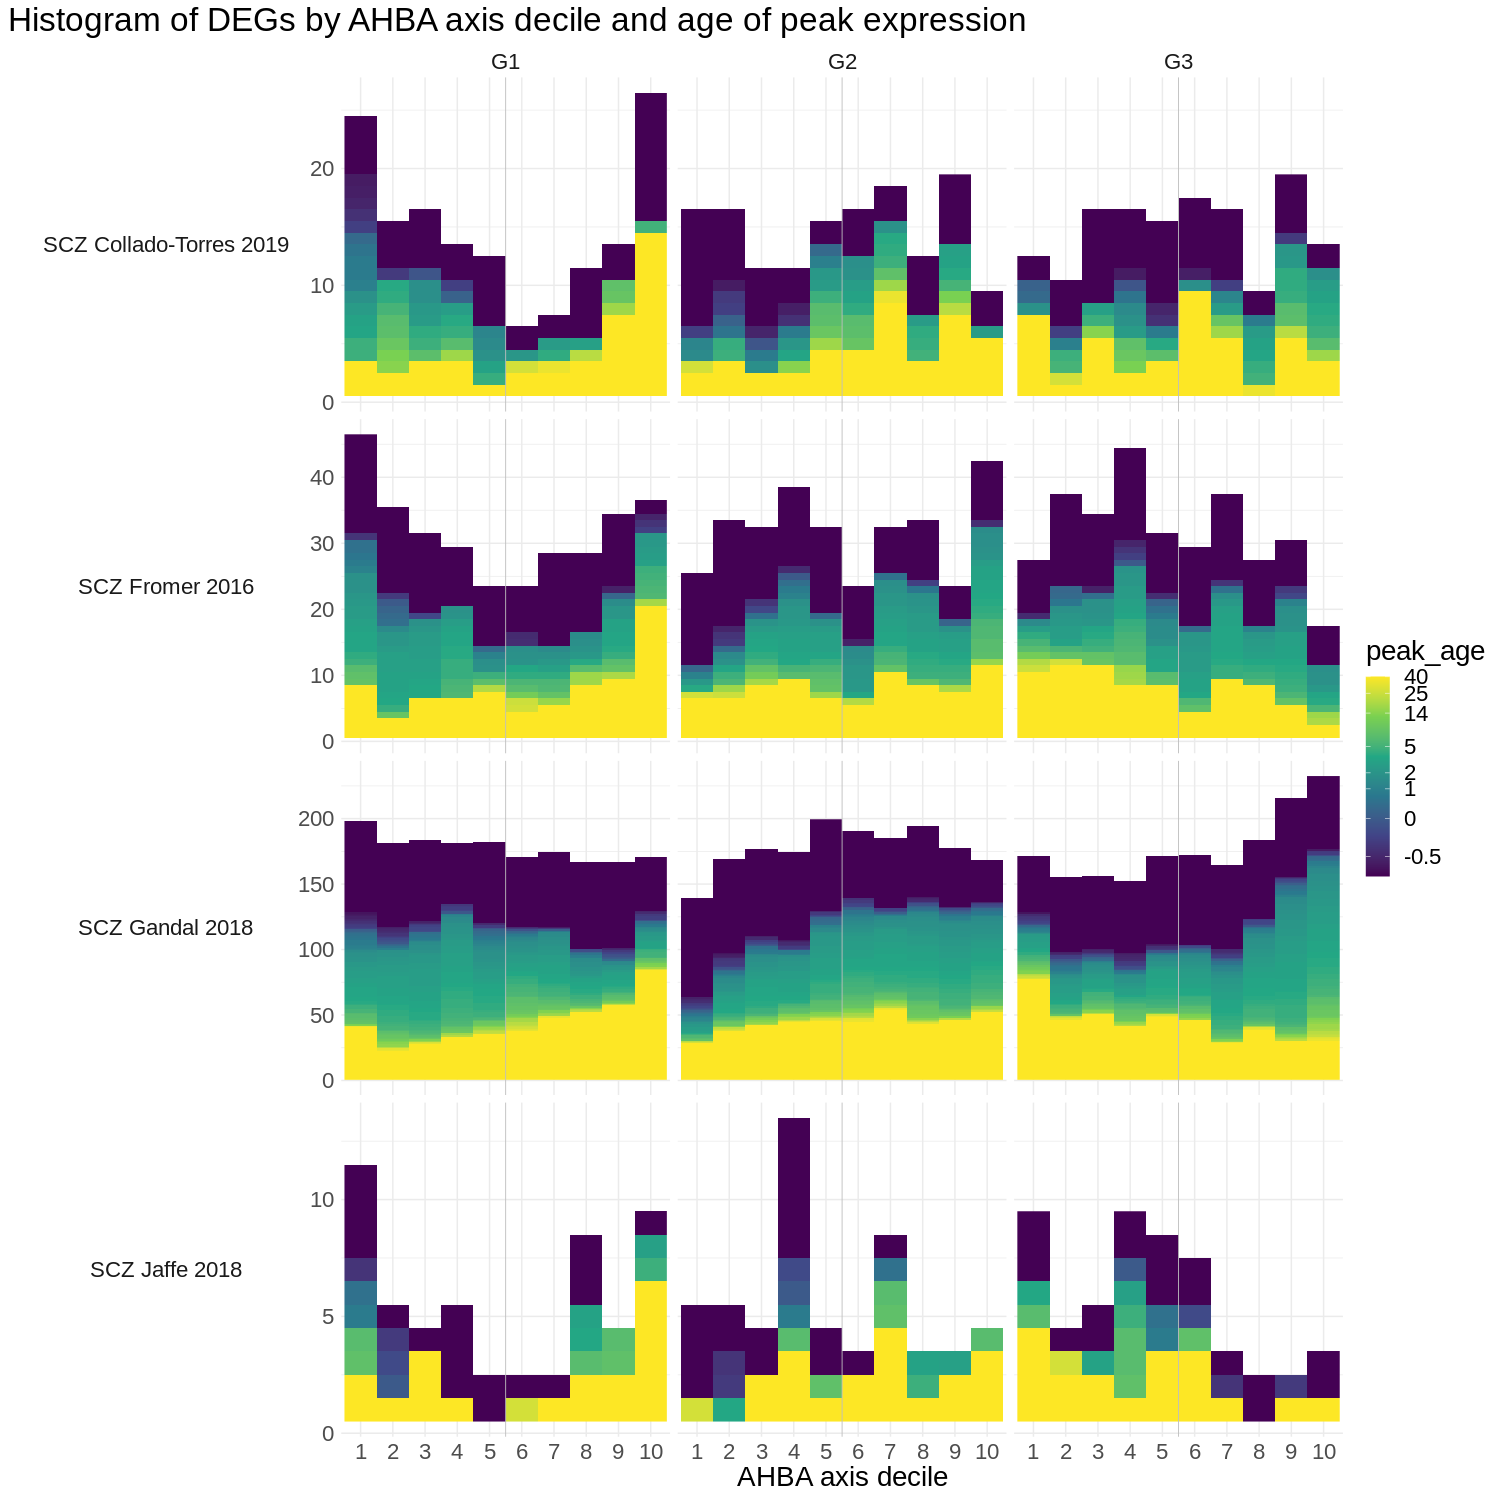

In [401]:
%%R -i peaks_plot_with_degs_only -w 15 -h 15 -u in -r 100
peaks_plot_with_degs_only %>% 
    ggplot(aes(x=G_decile, y=age_rank_in_decile)) +
    facet_grid(study~G, scales='free', switch='y') + 
    geom_raster(aes(fill=peak_age)) + 
    geom_vline(xintercept=5.5, color='grey', size=.3) +
    # scale_alpha_manual(values=c(.1,1)) +
    scale_fill_viridis_c(
    # scale_fill_gradientn(
        # colors=brewer.spectral(100),
        breaks=log10(c(-0.5,0,1,2,5,14,25,40)*365+40*7),
        labels=function(x) round((10**x - 40*7)/365,2)) + 
    scale_x_discrete(
        labels=function(x) as.integer(x)+1
    ) +
    guides(fill=guide_colorbar(barheight=10)) +
    ylab('') +
    xlab('AHBA axis decile') +
    ggtitle('Histogram of DEGs by AHBA axis decile and age of peak expression') +
    theme_minimal() + 
    theme(
        text=element_text(size=20),
        strip.text.y.left = element_text(angle=0),
        strip.placement='outside',
        plot.title.position='plot'
    )

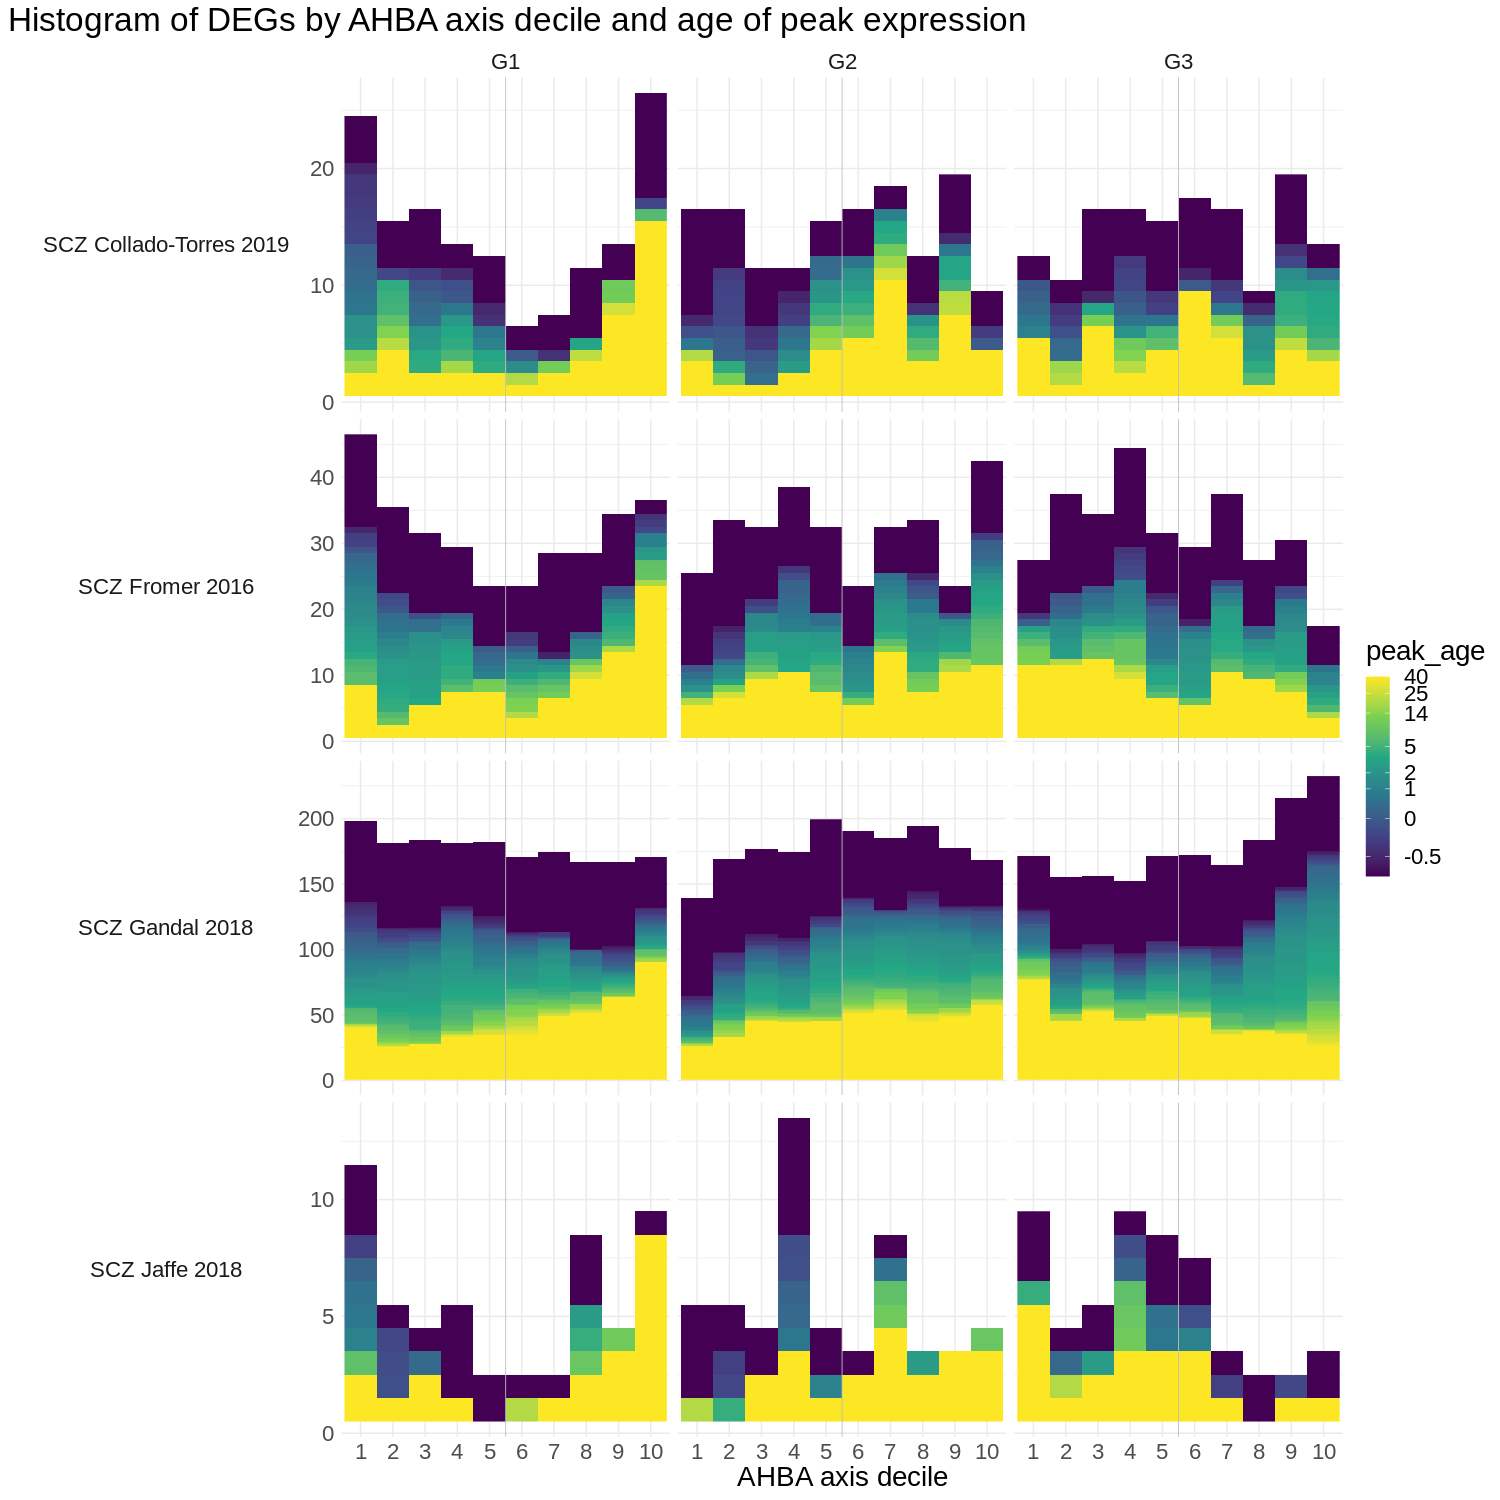

In [ ]:
%%R -i peaks_plot_with_degs_only -w 15 -h 15 -u in -r 100
peaks_plot_with_degs_only %>% 
    ggplot(aes(x=G_decile, y=age_rank_in_decile)) +
    facet_grid(study~G, scales='free', switch='y') + 
    geom_raster(aes(fill=peak_age)) + 
    geom_vline(xintercept=5.5, color='grey', size=.3) +
    # scale_alpha_manual(values=c(.1,1)) +
    scale_fill_viridis_c(
    # scale_fill_gradientn(
        # colors=brewer.spectral(100),
        breaks=log10(c(-0.5,0,1,2,5,14,25,40)*365+40*7),
        labels=function(x) round((10**x - 40*7)/365,2)) + 
    scale_x_discrete(
        labels=function(x) as.integer(x)+1
    ) +
    guides(fill=guide_colorbar(barheight=10)) +
    ylab('') +
    xlab('AHBA axis decile') +
    ggtitle('Histogram of DEGs by AHBA axis decile and age of peak expression') +
    theme_minimal() + 
    theme(
        text=element_text(size=20),
        strip.text.y.left = element_text(angle=0),
        strip.placement='outside',
        plot.title.position='plot'
    )

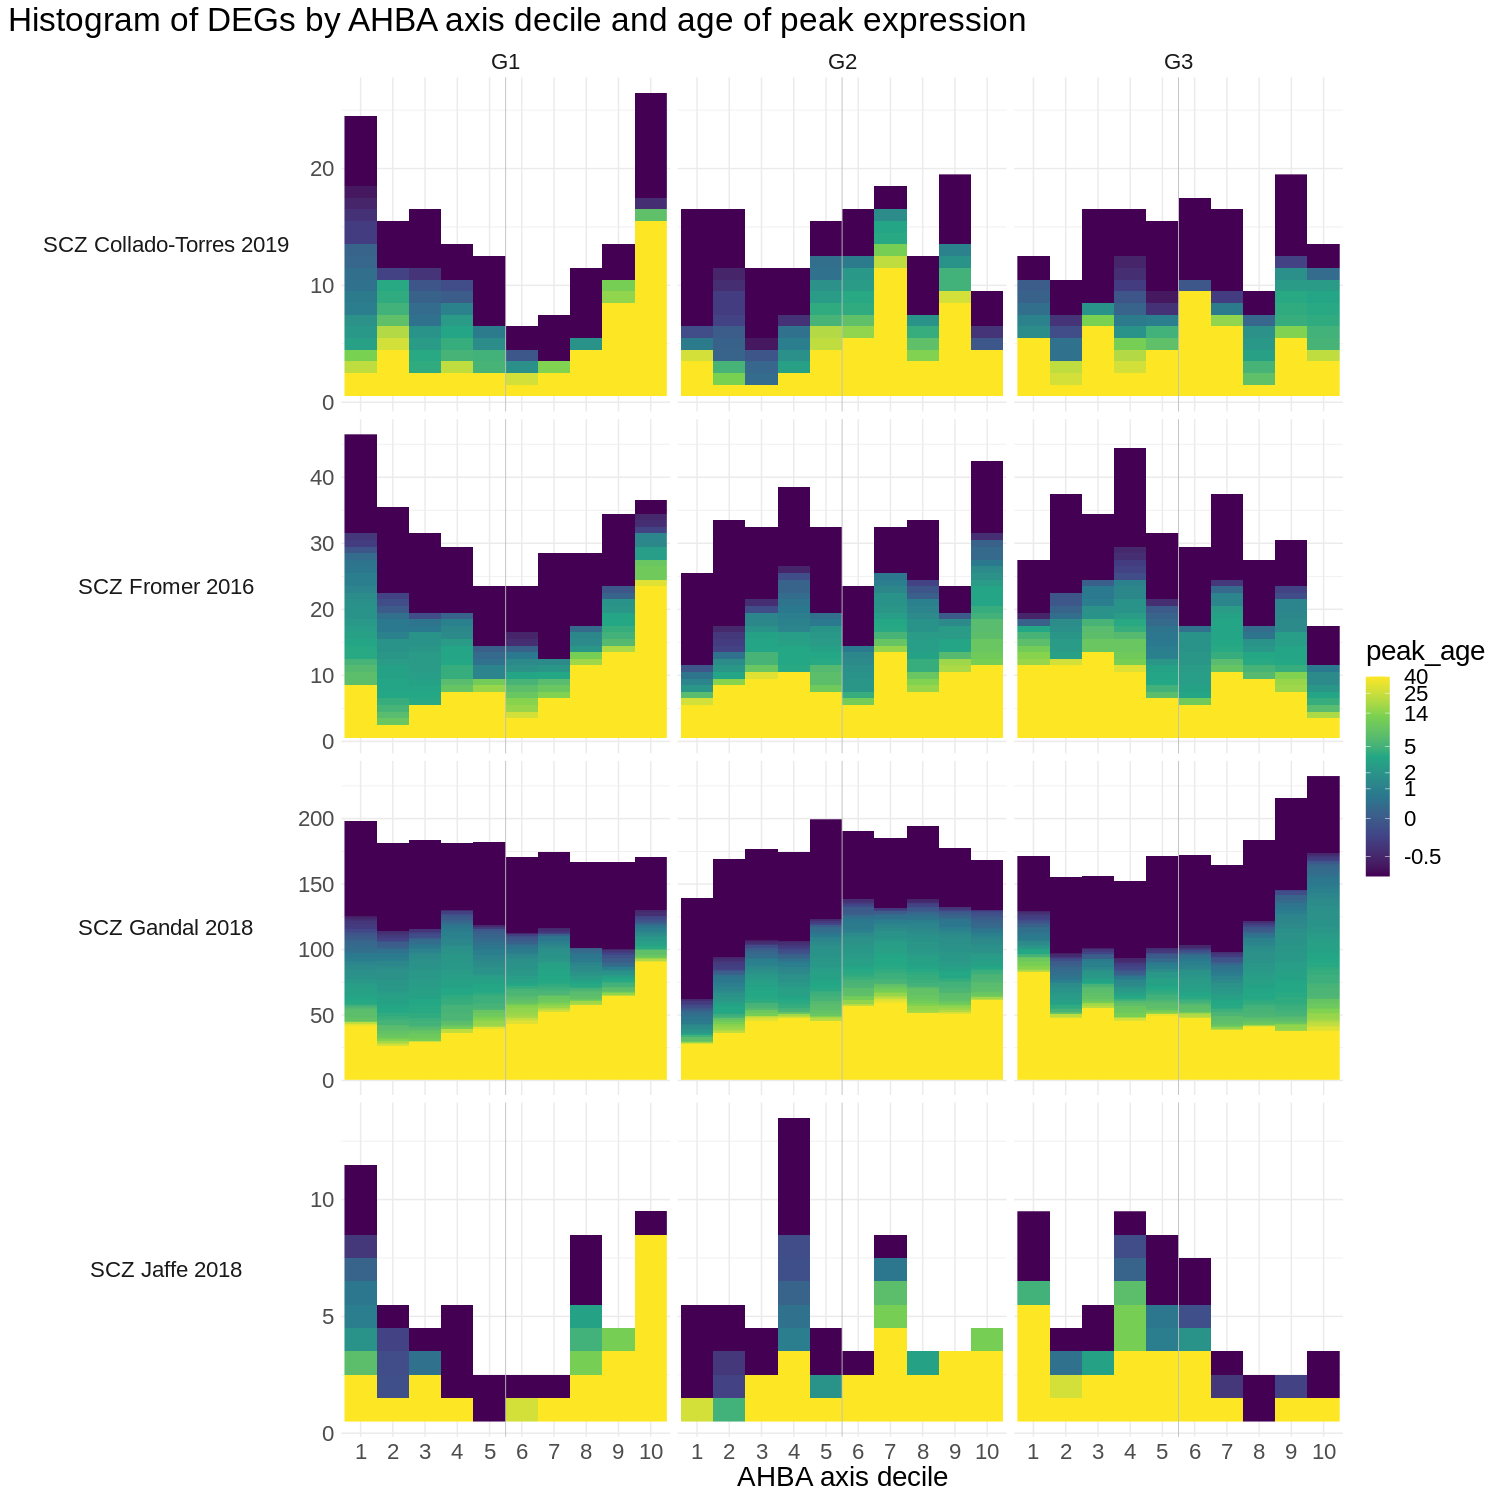

In [ ]:
%%R -i peaks_plot_with_degs_only -w 15 -h 15 -u in -r 100
peaks_plot_with_degs_only %>% 
    ggplot(aes(x=G_decile, y=age_rank_in_decile)) +
    facet_grid(study~G, scales='free', switch='y') + 
    geom_raster(aes(fill=peak_age)) + 
    geom_vline(xintercept=5.5, color='grey', size=.3) +
    # scale_alpha_manual(values=c(.1,1)) +
    scale_fill_viridis_c(
    # scale_fill_gradientn(
        # colors=brewer.spectral(100),
        breaks=log10(c(-0.5,0,1,2,5,14,25,40)*365+40*7),
        labels=function(x) round((10**x - 40*7)/365,2)) + 
    scale_x_discrete(
        labels=function(x) as.integer(x)+1
    ) +
    guides(fill=guide_colorbar(barheight=10)) +
    ylab('') +
    xlab('AHBA axis decile') +
    ggtitle('Histogram of DEGs by AHBA axis decile and age of peak expression') +
    theme_minimal() + 
    theme(
        text=element_text(size=20),
        strip.text.y.left = element_text(angle=0),
        strip.placement='outside',
        plot.title.position='plot'
    )